#### My practice on PyTorch:
Original sources of this practice can be found in this  PyTorch course
https://classroom.udacity.com/courses/ud188/

# Multi-Layer Perceptron, MNIST
---

In this notebook, we will train an MLP to classify images from the [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.

The process will be broken down into the following steps:
>1. Load and visualize the data
2. Define a neural network
3. Train the model
4. Evaluate the performance of our trained model on a test dataset!

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [8]:
# import libraries
import torch
import numpy as np
np.random.seed(123)

In [9]:
print(torch.__version__)

1.0.0.dev20181205


---
## Load and Visualize the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a few moments, and you should see your progress as the data is loading. You may also choose to change the `batch_size` if you want to load more data at a time.

This cell will create DataLoaders for each of our datasets.

In [23]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
print("train data length: ", len(train_data) )

test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)
print("test data length: ", len(test_data) )
# obtain training indices that will be used for validation
num_train = len(train_data)

indices = list(range(num_train))
print("train data indices", indices[:5], ". . .")

from random import Random
Random(123).shuffle(indices)  #for reproducable indices
print("train data indices", indices[:5], ". . .")

train data length:  60000
test data length:  10000
train data indices [0, 1, 2, 3, 4] . . .
train data indices [21549, 52860, 27886, 18533, 42642] . . .


In [24]:
split = int(np.floor(valid_size * num_train))
print('validation index length', split)
train_idx, valid_idx = indices[split:], indices[:split]
print('train index length', len(train_idx))

validation index length 12000
train index length 48000


In [27]:
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

print(len(valid_sampler))
type(train_sampler)

12000


torch.utils.data.sampler.SubsetRandomSampler

In [28]:
# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

print("length of train_loader"  , len(train_loader))
type(train_loader)

length of train_loader 2400


torch.utils.data.dataloader.DataLoader

In [33]:
print(batch_size)
print(batch_size * len(train_loader),   "should be same as ",len(train_idx))

20
48000 should be same as  48000


In [39]:
np.arange(3)

array([0, 1, 2])

### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

labels index 5 is:  1
imgages dimension:  torch.Size([20, 1, 28, 28])
labels length  20


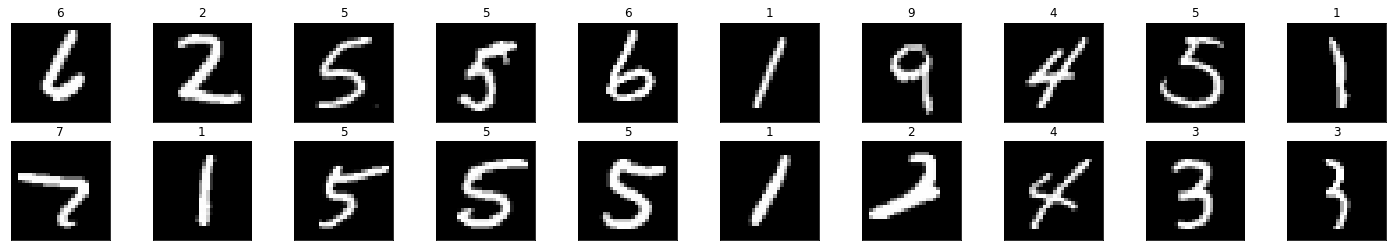

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
print("labels index 5 is: ", labels[5].item())
print("imgages dimension: ", images.shape)
print("labels length ", len(labels))
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

### View an Image in More Detail

(1, 28, 28)
sequeezed size:  (28, 28)


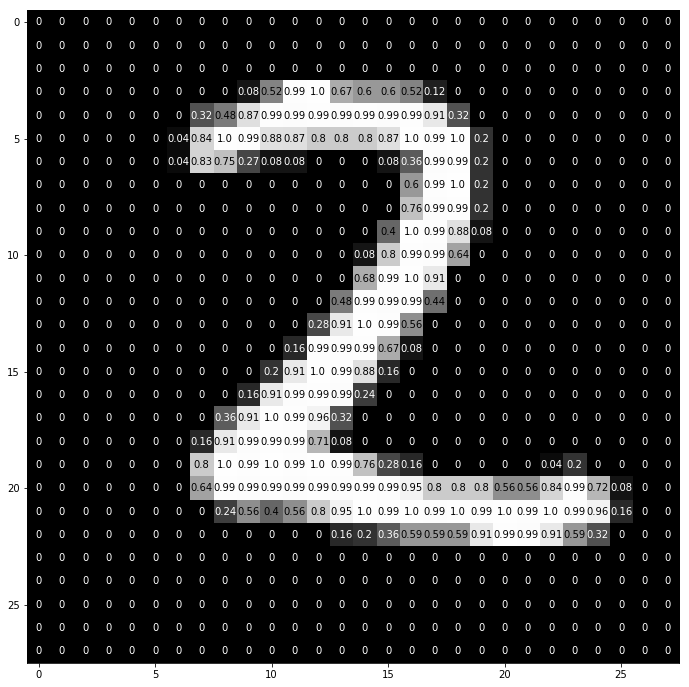

In [51]:
img = np.squeeze(images[1])
print(images[1].shape)
print("sequeezed size: ", img.shape)


fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [56]:
images, labels = dataiter.next()
print(images.shape)
img = images.view(-1, 28 * 28)
print(img.shape)
img

torch.Size([20, 1, 28, 28])
torch.Size([20, 784])


tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

The architecture will be responsible for seeing as input a 784-dim Tensor of pixel values for each image, and producing a Tensor of length 10 (our number of classes) that indicates the class scores for an input image. This particular example uses two hidden layers and dropout to avoid overfitting.

In [76]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # number of hidden nodes in each layer (512)
        hidden_1 = 512
        hidden_2 = 512
        # linear layer (784 -> hidden_1)
        self.fc1 = nn.Linear(28 * 28, hidden_1)
        # linear layer (n_hidden -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # linear layer (n_hidden -> 10)
        self.fc3 = nn.Linear(hidden_2, 10)
        # dropout layer (p=0.2)
        # dropout prevents overfitting of data
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.2)
)


###  Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

It's recommended that you use cross-entropy loss for classification. If you look at the documentation (linked above), you can see that PyTorch's cross entropy function applies a softmax funtion to the output layer *and* then calculates the log loss.

In [77]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

The following loop trains for 50 epochs; take a look at how the values for the training loss decrease over time. We want it to decrease while also avoiding overfitting the training data.

In [78]:
# number of epochs to train the model
n_epochs = 15

train_losses, test_losses = [], []

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

for epoch in range(n_epochs):
    # monitor training loss
    #This train_loss is the average training loss over all the samples of the whole train data that runs in one epoch.
    train_loss = 0.0
    #This valid_loss is the average validation loss over all the samples of the whole validation data 
    #   that runs after each epoch of training.
    valid_loss = 0.0
    
    #in order to keep track of each train_loss and valid_loss, I assigen them to
    #.   train_losses, test_losses lists at the end of each epoch. test_losses would be better named as valid_losses 
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        #data: a batch of data images loaded into data
        # clear the gradients of all optimized variables. This is a standard required step in PyTorch. 
        optimizer.zero_grad() 
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0) 
        # loss.item() already provides average loss for the batch of images.
        # to get the total loss of the batch, the average is multiplied by the #images in the batch.
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    #total losses are divided by the #all images in the wholde train and valid datasets and got average losses.
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    
    train_losses.append(train_loss)
    test_losses.append(valid_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))
    
    # save model if validation loss has decreased
    if (valid_loss <= valid_loss_min) and epoch > 10: #let it run 10 epocs before start saving models
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss
        final_epoch = epoch


Epoch: 1 	Training Loss: 0.486352 	Validation Loss: 0.076181
Epoch: 2 	Training Loss: 0.405880 	Validation Loss: 0.064053
Epoch: 3 	Training Loss: 0.377919 	Validation Loss: 0.068834
Epoch: 4 	Training Loss: 0.370247 	Validation Loss: 0.065905
Epoch: 5 	Training Loss: 0.363626 	Validation Loss: 0.052971
Epoch: 6 	Training Loss: 0.357143 	Validation Loss: 0.051617
Epoch: 7 	Training Loss: 0.360242 	Validation Loss: 0.057284
Epoch: 8 	Training Loss: 0.332983 	Validation Loss: 0.064548
Epoch: 9 	Training Loss: 0.333137 	Validation Loss: 0.073074
Epoch: 10 	Training Loss: 0.331520 	Validation Loss: 0.064386
Epoch: 11 	Training Loss: 0.324065 	Validation Loss: 0.059491
Epoch: 12 	Training Loss: 0.348151 	Validation Loss: 0.061811
Validation loss decreased (inf --> 0.061811).  Saving model ...
Epoch: 13 	Training Loss: 0.316412 	Validation Loss: 0.057302
Validation loss decreased (0.061811 --> 0.057302).  Saving model ...
Epoch: 14 	Training Loss: 0.306283 	Validation Loss: 0.070336
Epoch: 1

the last model is saved at epoch  12


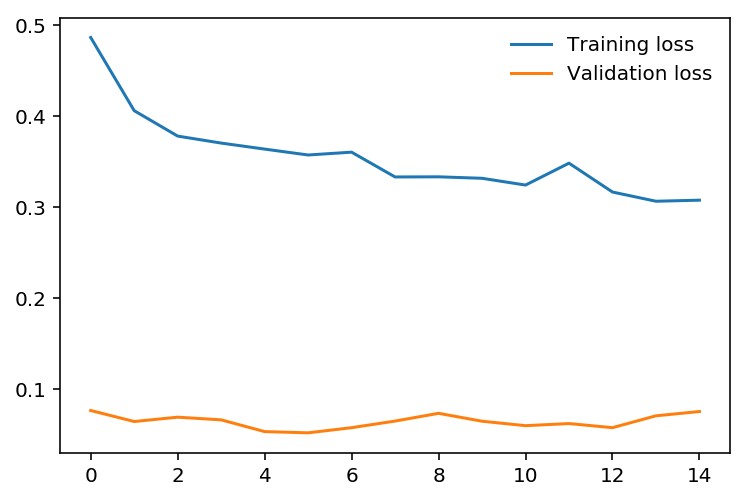

In [79]:

# plot train and validation loss        
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt    
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
print("the last model is saved at epoch ", final_epoch)

###  Load the Model with the Lowest Validation Loss

In [80]:
model.load_state_dict(torch.load('model.pt'))

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

In [81]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.345892

Test Accuracy of     0: 98% (962/980)
Test Accuracy of     1: 97% (1109/1135)
Test Accuracy of     2: 94% (978/1032)
Test Accuracy of     3: 92% (936/1010)
Test Accuracy of     4: 93% (920/982)
Test Accuracy of     5: 90% (807/892)
Test Accuracy of     6: 96% (922/958)
Test Accuracy of     7: 96% (994/1028)
Test Accuracy of     8: 92% (902/974)
Test Accuracy of     9: 94% (951/1009)

Test Accuracy (Overall): 94% (9481/10000)


### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

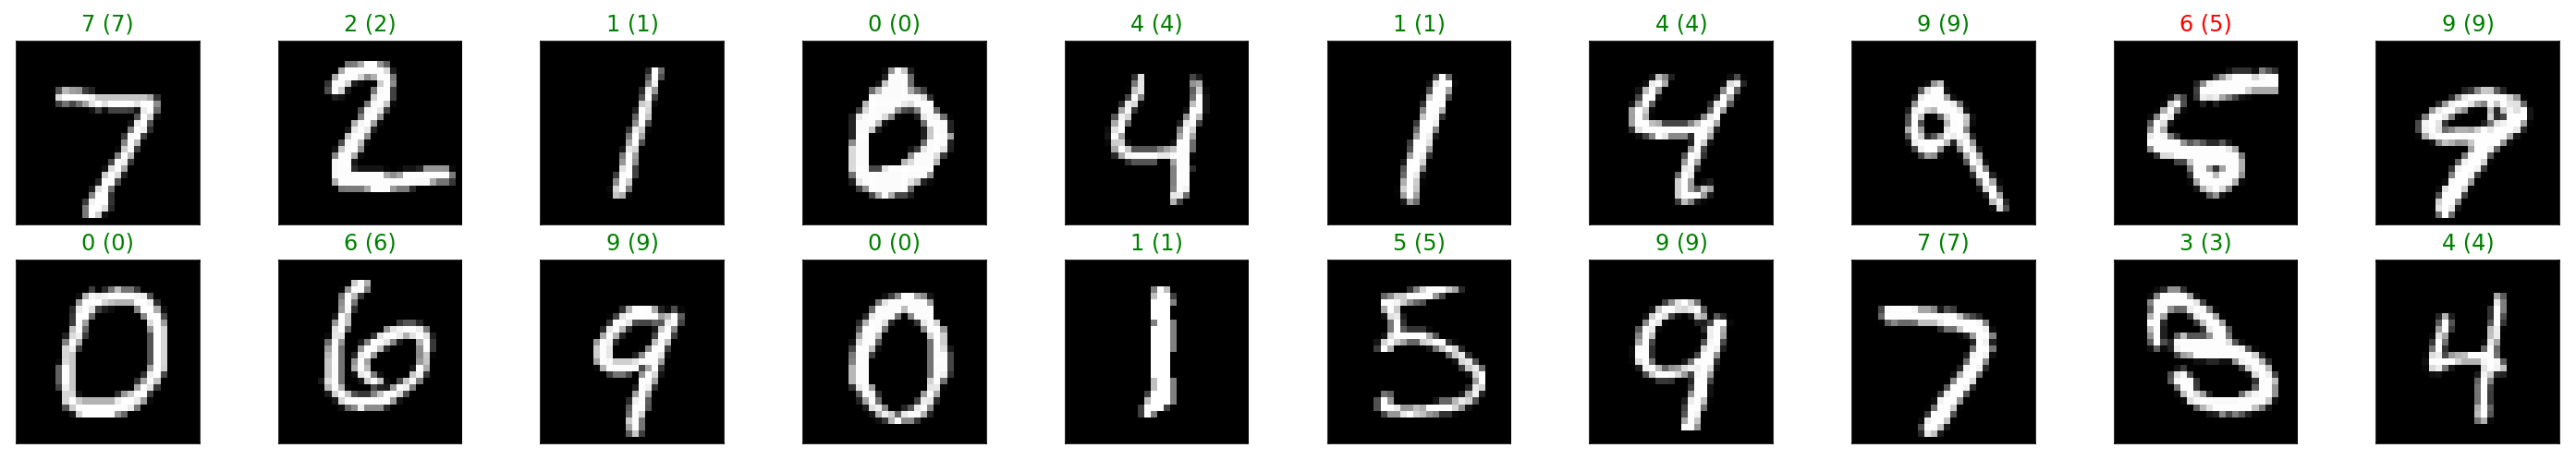

In [102]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
ps, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

In [105]:
preds[0].item()

7

In [104]:
ps.shape

torch.Size([20])

In [106]:
output.shape

torch.Size([20, 10])

In [137]:
output[0]

tensor([-143.6205,  -59.2340,  -24.4755,    0.6939,  -44.4602,  -80.5273,
        -386.8469,   87.6543,  -84.2585,    1.5328], grad_fn=<SelectBackward>)

In [138]:
output[0].shape

torch.Size([10])

In [170]:
print(type(images))
print(images.shape)
img = images[0]
print(type(img))
img.shape

<class 'numpy.ndarray'>
(20, 1, 28, 28)
<class 'numpy.ndarray'>


(1, 28, 28)

In [142]:
#calculate probablities from scores of the first image in the outputs of a batch
#this probability calculation is called softmax
a1 = torch.exp(output[0])
a1

tensor([0.0000e+00, 1.8836e-26, 2.3464e-11, 2.0016e+00, 4.9109e-20, 1.0652e-35,
        0.0000e+00, 1.1689e+38, 2.5526e-37, 4.6313e+00], grad_fn=<ExpBackward>)

In [145]:
a2 = torch.sum(torch.exp(output[0])).view(-1, 1)
a2

tensor([[1.1689e+38]], grad_fn=<ViewBackward>)

In [146]:
a3= a1/a2
a3  

tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7124e-38, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 1.0000e+00, 0.0000e+00, 3.9622e-38]],
       grad_fn=<DivBackward0>)

In [147]:
torch.sum(a3)

tensor(1., grad_fn=<SumBackward0>)

In [149]:
img.shape

(1, 28, 28)

In [167]:
def softmax(x):
    return torch.exp(x)/torch.sum(torch.exp(x), dim=1).view(-1, 1)

probabilities = softmax(output)
probabilities[0] 

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 1.7124e-38, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 3.9622e-38],
       grad_fn=<SelectBackward>)

In [168]:
probabilities[0] == a3

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=torch.uint8)

In [171]:
#Lets see the probabilities of the incorrect prediction at index 8
probabilities[8]

tensor([3.0267e-16, 3.6093e-18, 6.0337e-22, 1.0280e-19, 6.8547e-25, 5.2104e-08,
        1.0000e+00, 4.9983e-39, 3.2513e-14, 3.2465e-27],
       grad_fn=<SelectBackward>)